# Portfolio's Building #

### Rebalancing Weights ###

In [241]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Optiminization
from scipy.optimize import minimize

# Pretty Notation
from IPython.display import display, Math

In [242]:
def import_financial_data(
    ticker: str
):

    # Check the ticker for Upper Cases
    ticker = ticker if ticker.isupper() else ticker.upper()

    # Import data
    df = pd.read_csv(rf"..\stocks\{ticker}.csv")

    # Set the Index
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)

    df_useful_data = df[['Open Price', 'High Price', 'Low Price', 'Close Price', 'Adjusted_close']]

    df_useful_data = df_useful_data.rename(columns={
        "Open Price":"open",
        "High Price":"high",
        "Low Price":"low",
        "Close Price":"close",
        "Adjusted_close":"adjusted_close",
    })

    # Drop NaN's
    df_useful_data.dropna(inplace = True)

    return df_useful_data.loc["2013-01-01":]

In [243]:
# Import Data

# Apple Data
df_1 = import_financial_data("AAPL")

# Amazon Data
df_2 =  import_financial_data("AMZN")

# Meta Data
df_3 =  import_financial_data("META")

# Microsoft Data
df_4 =  import_financial_data("MSFT")

# Nvidia Data
df_5 =  import_financial_data("NVDA")

In [244]:
# Create the joint dataframe

df_data = pd.DataFrame()

df_data['AAPL'] = df_1['close']
df_data['AMZN'] = df_2['close']
df_data['META'] = df_3['close']
df_data['MSFT'] = df_4['close']
df_data['NVDA'] = df_5['close']

df_data = df_data.dropna()

df_returns = df_data.pct_change(1).mul(100)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2013-01-02,0.098975,0.110800,0.130895,0.105831,0.245589
2013-01-03,-1.200299,0.446897,-0.839286,-1.373825,0.078616
2013-01-04,-2.842712,0.259208,3.583648,-1.832845,3.377848
2013-01-07,-0.542675,3.611808,2.364395,-0.224048,-2.963526
2013-01-08,0.200321,-0.793267,-1.290761,-0.636228,-2.114330
...,...,...,...,...,...
2024-10-22,-0.262179,0.333210,1.190973,2.084627,-0.083501
2024-10-23,-2.162300,-2.630469,-3.147712,-0.680686,-2.806602
2024-10-24,-0.082337,0.904120,0.725576,0.030617,0.609057


In [245]:
df_returns.mean()

AAPL    0.098975
AMZN    0.110800
META    0.130895
MSFT    0.105831
NVDA    0.245589
dtype: float64

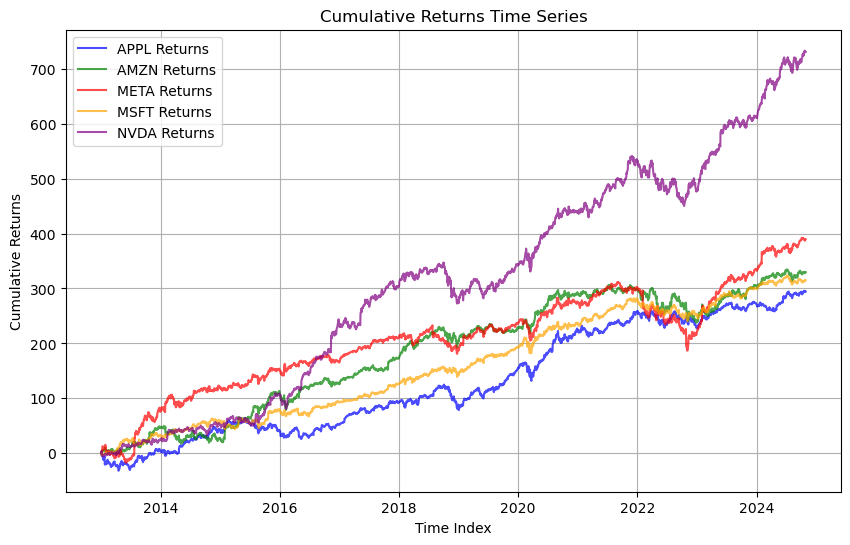

In [246]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns['AAPL'].cumsum(), label='APPL Returns', color='blue', alpha=0.7)
plt.plot(df_returns['AMZN'].cumsum(), label='AMZN Returns', color='green', alpha=0.7)
plt.plot(df_returns['META'].cumsum(), label='META Returns', color='red', alpha=0.7)
plt.plot(df_returns['MSFT'].cumsum(), label='MSFT Returns', color='orange', alpha=0.7)
plt.plot(df_returns['NVDA'].cumsum(), label='NVDA Returns', color='purple', alpha=0.7)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

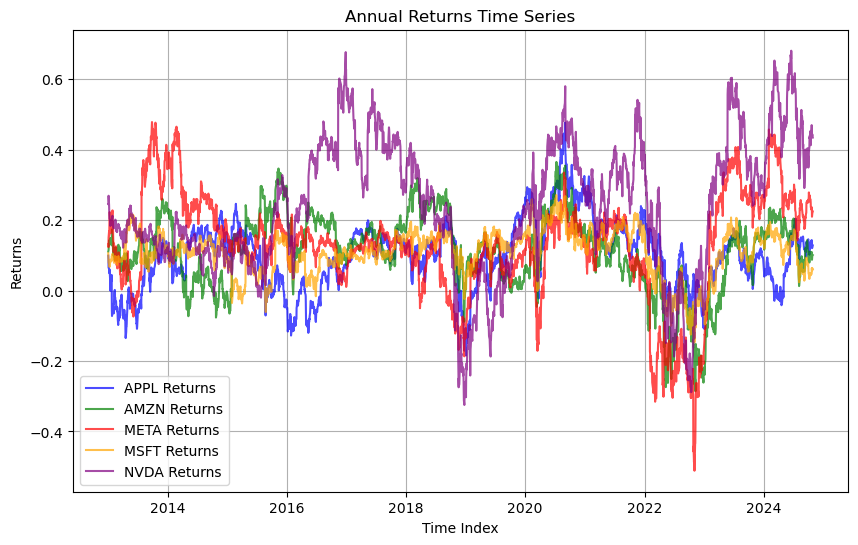

In [247]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns['AAPL'].ewm(span=252, adjust=False).mean(), label='APPL Returns', color='blue', alpha=0.7)
plt.plot(df_returns['AMZN'].ewm(span=252, adjust=False).mean(), label='AMZN Returns', color='green', alpha=0.7)
plt.plot(df_returns['META'].ewm(span=252, adjust=False).mean(), label='META Returns', color='red', alpha=0.7)
plt.plot(df_returns['MSFT'].ewm(span=252, adjust=False).mean(), label='MSFT Returns', color='orange', alpha=0.7)
plt.plot(df_returns['NVDA'].ewm(span=252, adjust=False).mean(), label='NVDA Returns', color='purple', alpha=0.7)

# Config
plt.title('Annual Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [248]:
# Create the DataFrame with average returns

df_mean_returns = df_returns.apply(lambda x: x.ewm(span=252, adjust=False).mean().mul(252), axis=0)

df_mean_returns

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2013-01-02,24.941584,27.921650,32.985492,26.669317,61.888348
2013-01-03,22.353308,28.591187,31.052800,23.721702,61.555724
2013-01-04,16.513650,28.881536,37.946291,19.882979,67.798110
2013-01-07,15.302047,35.848287,42.356420,19.279476,61.358532
2013-01-08,15.580140,33.984639,39.450268,17.859644,56.661537
...,...,...,...,...,...
2024-10-22,35.316405,27.444450,59.541384,15.998290,117.211212
2024-10-23,30.729718,21.987354,52.800159,14.515831,110.693624
2024-10-24,30.322773,23.614634,53.828183,14.462073,111.031875


In [249]:
# Let us Calculate the Weights

def rolling_weights(
    returns, 
    desired_returns, 
    window=252, 
    rebalance_freq=126
):

    # Lists to Store Things
    weights_list = []
    dates = []

    for i in range(window, len(returns), rebalance_freq):
        past_returns = returns.iloc[i-window:i]  # Rolling Window
        
        # Mean and Covariance
        mu = past_returns.mean()
        Sigma = past_returns.cov()
        Sigma_inv = np.linalg.inv(Sigma)
        iota = np.ones(len(mu))

        # Markowitz Components
        A = mu @ Sigma_inv @ mu
        B = mu @ Sigma_inv @ iota
        C = iota @ Sigma_inv @ iota
        D = (A * C) - (B ** 2)

        w = (((desired_returns * C) - B) / D) * (Sigma_inv @ mu) + \
            ((A - (desired_returns * B)) / D) * (Sigma_inv @ iota)

        # Save weights and dates
        weights_list.append(w)
        dates.append(returns.index[i])

    # Create the DataFrame
    weights_df = pd.DataFrame(weights_list, index=dates, columns=returns.columns)

    # Expand the DataFrame
    weights_df = weights_df.reindex(returns.index, method='ffill')

    return weights_df.dropna()

In [250]:
# Create the DataFrames of Returns

df_weights = rolling_weights(df_returns, 0.2)

df_weights

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2014-01-02,-0.053933,0.394321,0.250787,0.292483,0.116342
2014-01-03,-0.053933,0.394321,0.250787,0.292483,0.116342
2014-01-06,-0.053933,0.394321,0.250787,0.292483,0.116342
2014-01-07,-0.053933,0.394321,0.250787,0.292483,0.116342
2014-01-08,-0.053933,0.394321,0.250787,0.292483,0.116342
...,...,...,...,...,...
2024-10-22,0.277754,0.119231,0.064504,0.349481,0.189031
2024-10-23,0.277754,0.119231,0.064504,0.349481,0.189031
2024-10-24,0.277754,0.119231,0.064504,0.349481,0.189031


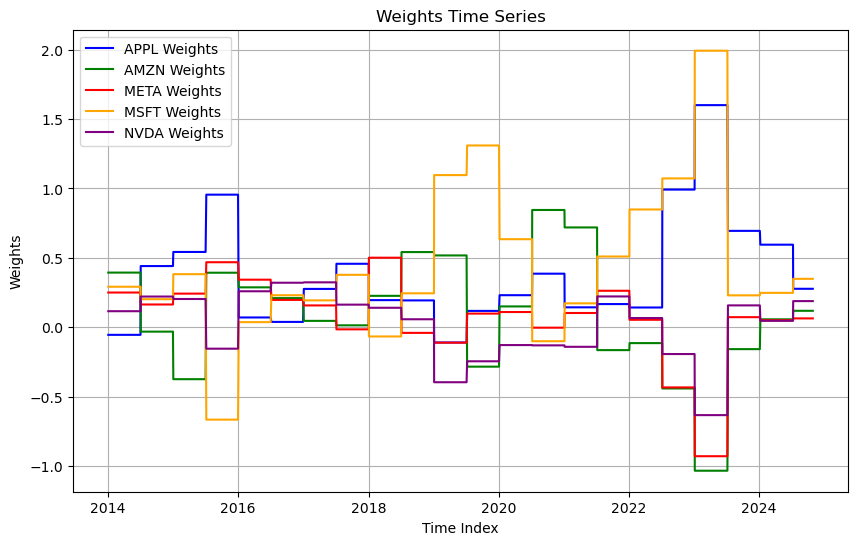

In [251]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_weights['AAPL'], label='APPL Weights', color='blue', alpha=1)
plt.plot(df_weights['AMZN'], label='AMZN Weights', color='green', alpha=1)
plt.plot(df_weights['META'], label='META Weights', color='red', alpha=1)
plt.plot(df_weights['MSFT'], label='MSFT Weights', color='orange', alpha=1)
plt.plot(df_weights['NVDA'], label='NVDA Weights', color='purple', alpha=1)

# Config
plt.title('Weights Time Series')
plt.xlabel('Time Index')
plt.ylabel('Weights')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [252]:
# Common Index

common_index = df_returns.index.intersection(df_weights.index)  # Fechas en común
df_returns_reindex = df_returns.reindex(common_index)
df_weights = df_weights.reindex(common_index)

df_returns_reindex

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2014-01-02,-1.422182,-0.205622,0.109769,-0.721347,-0.998752
2014-01-03,-2.196590,-0.384451,-0.310673,-0.672766,-1.197982
2014-01-06,0.545306,-0.708808,4.857929,-2.031970,1.340140
2014-01-07,-0.698619,1.117801,1.276224,0.691372,1.637280
2014-01-08,0.616516,0.977313,0.517866,-1.785224,1.363073
...,...,...,...,...,...
2024-10-22,-0.262179,0.333210,1.190973,2.084627,-0.083501
2024-10-23,-2.162300,-2.630469,-3.147712,-0.680686,-2.806602
2024-10-24,-0.082337,0.904120,0.725576,0.030617,0.609057


In [253]:
# Create the Portfolio Returns

df_weighted_returns = df_returns_reindex * df_weights

df_weighted_returns

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2014-01-02,0.076702,-0.081081,0.027529,-0.210981,-0.116196
2014-01-03,0.118468,-0.151597,-0.077913,-0.196772,-0.139375
2014-01-06,-0.029410,-0.279498,1.218307,-0.594316,0.155914
2014-01-07,0.037678,0.440773,0.320061,0.202214,0.190484
2014-01-08,-0.033250,0.385375,0.129874,-0.522147,0.158582
...,...,...,...,...,...
2024-10-22,-0.072821,0.039729,0.076822,0.728537,-0.015784
2024-10-23,-0.600587,-0.313633,-0.203039,-0.237887,-0.530535
2024-10-24,-0.022869,0.107799,0.046802,0.010700,0.115131


In [254]:
# Create the Portfolio Returns
df_returns_portfolio = df_returns.copy()

# Add the columns
df_returns_portfolio['Portfolio'] =  df_weighted_returns.sum(axis = 1)

df_returns_portfolio['Portfolio'].dropna()

Date
2014-01-02   -0.304028
2014-01-03   -0.447189
2014-01-06    0.470997
2014-01-07    1.191210
2014-01-08    0.118435
                ...   
2024-10-22    0.756483
2024-10-23   -1.885680
2024-10-24    0.257563
2024-10-25    0.689629
2024-10-28    0.066089
Name: Portfolio, Length: 2724, dtype: float64

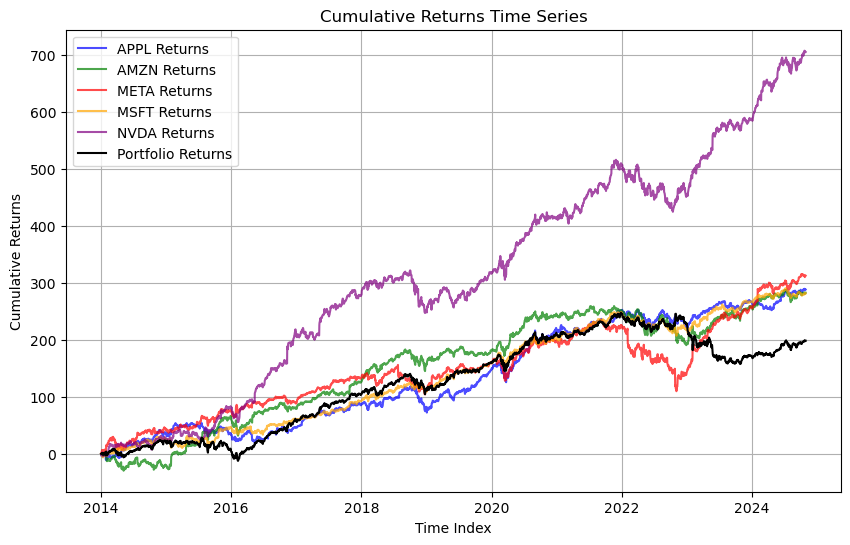

In [255]:
# Time Series Graphs

df_plot = df_returns_portfolio.dropna()

plt.figure(figsize=(10, 6))
plt.plot(df_plot['AAPL'].cumsum(), label='APPL Returns', color='blue', alpha=0.7)
plt.plot(df_plot['AMZN'].cumsum(), label='AMZN Returns', color='green', alpha=0.7)
plt.plot(df_plot['META'].cumsum(), label='META Returns', color='red', alpha=0.7)
plt.plot(df_plot['MSFT'].cumsum(), label='MSFT Returns', color='orange', alpha=0.7)
plt.plot(df_plot['NVDA'].cumsum(), label='NVDA Returns', color='purple', alpha=0.7)
plt.plot(df_plot['Portfolio'].cumsum(), label='Portfolio Returns', color='black', alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

### Define different rebalancing frequencies ###

In [257]:
# Create weights for different rebalancing frecuencies

df_weights_5d = rolling_weights(df_returns, 0.25, rebalance_freq=5)
df_weights_21d = rolling_weights(df_returns, 0.25, rebalance_freq=21)
df_weights_63d = rolling_weights(df_returns, 0.25, rebalance_freq=63)
df_weights_126d = rolling_weights(df_returns, 0.25, rebalance_freq=126)
df_weights_252d = rolling_weights(df_returns, 0.25, rebalance_freq=252)

In [258]:
# Create the Returns

df_weighted_returns_5d = df_returns_reindex * df_weights_5d
df_weighted_returns_21d = df_returns_reindex * df_weights_21d
df_weighted_returns_63d = df_returns_reindex * df_weights_63d
df_weighted_returns_126d = df_returns_reindex * df_weights_126d
df_weighted_returns_252d = df_returns_reindex * df_weights_252d

In [259]:
# Add the columns

df_returns_reindex['5d_port'] = df_weighted_returns_5d.sum(axis = 1)
df_returns_reindex['21d_port'] = df_weighted_returns_21d.sum(axis = 1)
df_returns_reindex['63d_port'] = df_weighted_returns_63d.sum(axis = 1)
df_returns_reindex['126d_port'] = df_weighted_returns_126d.sum(axis = 1)
df_returns_reindex['252d_port'] = df_weighted_returns_252d.sum(axis = 1)

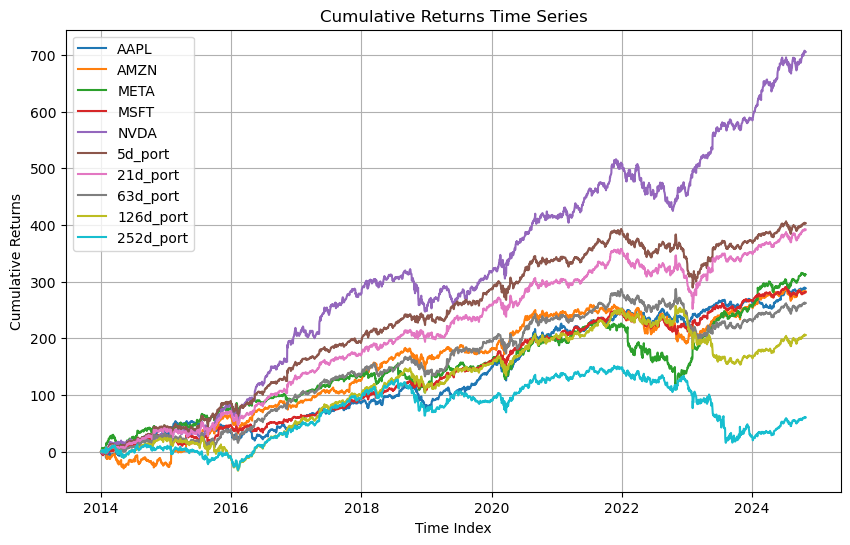

In [260]:
# Time Series Graphs

plt.figure(figsize=(10, 6))
plt.plot(df_returns_reindex.cumsum(), label=df_returns_reindex.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

### Comparing Portfolios ###

In [262]:
def calculate_analytics(df_returns, risk_free_rate=0.0):
    # Trading Days in one Year
    ann_factor = 252  
    
    # Annualized Returns
    annualized_return = df_returns.mean() * ann_factor
    
    # Annualized Volatility
    annualized_std = df_returns.std() * np.sqrt(ann_factor)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std
    
    # Max Drawdown
    cumulative_returns = (1 + df_returns.div(100)).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / rolling_max) - 1
    max_drawdown = drawdown.min()

    # VaR at 95%
    var_95 = df_returns.quantile(0.05)

    # Create DF
    summary_df = pd.DataFrame({
        "Annualized Returns": annualized_return,
        "Annualized Volatility": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "VaR 95%": var_95
    })
    
    return summary_df

In [263]:
# Now the table
analytics_table = calculate_analytics(df_returns_reindex)

analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
AAPL,26.660038,28.066192,0.949899,-0.387297,-2.659427
AMZN,26.126591,32.730869,0.798225,-0.561453,-3.067447
META,28.909030,37.451342,0.771909,-0.767361,-3.326259
MSFT,26.043041,26.554135,0.980753,-0.375565,-2.589296
NVDA,65.245377,47.108735,1.384995,-0.663621,-4.312351
5d_port,37.267927,34.857358,1.069155,-0.688709,-3.300441
21d_port,36.226173,35.384130,1.023797,-0.696483,-3.312729
63d_port,24.234797,34.040364,0.711943,-0.659100,-3.410109
126d_port,19.021099,34.446920,0.552186,-0.697608,-3.581798
252d_port,5.556896,35.477825,0.156630,-0.797917,-3.581458
